In [14]:
!pip install geopandas
!pip install contextily

In [15]:
from maap.maap import MAAP
maap = MAAP(maap_host='api.maap-project.org')

def job_status_for(job_id: str) -> str:
    response = maap.getJobStatus(job_id)
    response.raise_for_status()
   
    root = ET.fromstring(response.text)
    status_element = root.find('.//{http://www.opengis.net/wps/2.0}Status')
   
    return status_element.text

def job_result_for(job_id: str) -> str:
    response = maap.getJobResult(job_id)
    response.raise_for_status()
   
    root = ET.fromstring(response.text)

    return root.find('.//{http://www.opengis.net/wps/2.0}Data').text

def to_job_output_dir(job_result_url: str) -> str:
    url_path = urlparse(job_result_url).path
    # The S3 Key is the URL path excluding the `/{username}` prefix
    s3_key = "/".join(url_path.split("/")[2:])

    return f"/projects/my-private-bucket/{s3_key}"

def wait_for_job(job_id: str) -> str:
    return job_status_for(job_id)

In [16]:
#pip install geopandas
#pip install shapely
#Import numpy for making column inputs easier
import numpy as np
import geopandas as gpd
import backoff
import shapely
import glob
import os

In [17]:
import xml.etree.ElementTree as ET
from urllib.parse import urlparse

def job_status_for(job_id: str) -> str:
    response = maap.getJobStatus(job_id)
    response.raise_for_status()
    
    root = ET.fromstring(response.text)
    status_element = root.find('.//{http://www.opengis.net/wps/2.0}Status')
    
    return status_element.text

def job_result_for(job_id: str) -> str:
    response = maap.getJobResult(job_id)
    response.raise_for_status()
    
    root = ET.fromstring(response.text)

    return root.find('.//{http://www.opengis.net/wps/2.0}Data').text

def to_job_output_dir(job_result_url: str) -> str:
    url_path = urlparse(job_result_url).path
    # The S3 Key is the URL path excluding the `/{username}` prefix
    s3_key = "/".join(url_path.split("/")[2:])

    return f"/projects/my-private-bucket/{s3_key}"

In [18]:
# Define the folder path containing the tiles
#folder_path = "/projects/my-public-bucket/AOIs/GHANA/"
folder_path = "/projects/shared-buckets/nehajo88/Data/NASA_CMS_2023/CAMBODIA/"

# Create a list to store the GeoPackage file paths
json_files = []

# Use glob to find all .gpkg files in the folder
#pattern = os.path.join(folder_path, '*.geojson')
pattern = os.path.join(folder_path, 'NPAs.gpkg')
json_files = glob.glob(pattern)

# Print the list of GeoPackage file paths
#for file_path in gpkg_files:
 #   print(file_path)

#json_files = [x.replace('/projects/my-public-bucket/AOIs/GHANA/',
#                        'https://maap-ops-workspace.s3.amazonaws.com/shared/leitoldv/AOIs/GHANA/') for x in json_files]
json_files = [x.replace('/projects/shared-buckets/nehajo88/Data/NASA_CMS_2023/CAMBODIA/',
                        'https://maap-ops-workspace.s3.amazonaws.com/shared/nehajo88/Data/NASA_CMS_2023/CAMBODIA/') for x in json_files]

print(len(json_files))
print(json_files)

1
['https://maap-ops-workspace.s3.amazonaws.com/shared/nehajo88/Data/NASA_CMS_2023/CAMBODIA/NPAs.gpkg']


In [19]:
AOIs = json_files
AOIs[0]

'https://maap-ops-workspace.s3.amazonaws.com/shared/nehajo88/Data/NASA_CMS_2023/CAMBODIA/NPAs.gpkg'

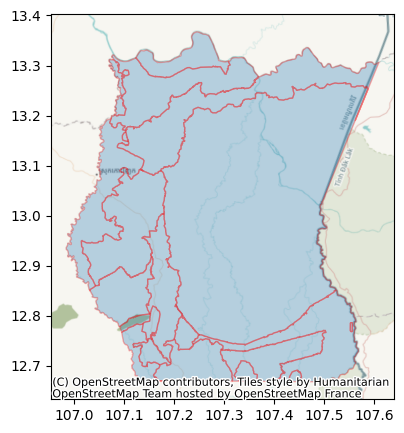

In [20]:
# OPTIONAL # visually verify the AOI
aoi = AOIs[0]

try:
    import geopandas as gpd
    import contextily as ctx
except:
    print(
        "If you wish to visually verify your AOI, "
        "you must install the `geopandas` and `contextily` packages."
    )
else:
    aoi_gdf = gpd.read_file(aoi)
    aoi_epsg4326 = aoi_gdf.to_crs(epsg=4326)
    ax = aoi_epsg4326.plot(figsize=(10, 5), alpha=0.3, edgecolor="red")
    ctx.add_basemap(ax, crs=4326)

In [21]:
aoi_name = os.path.basename(AOIs[0]).split('.')[0]
aoi_name

'NPAs'

In [21]:
## Needed For L2B ## Create empty variables to fill with all 29 appearances of cover_z* and pai_z* 

#variables = []
#for n in np.arange(0, 30,1):
#   variables.append('cover_z' + str(n))
#    variables.append('pai_z' + str(n))

In [9]:
#Set up run to pull products for all GEDI products simultaneously #To run for only 1 or 2 products, change "PRODUCTS"

PRODUCTS = ["L2A", "L4A"] # ,"L2A","L2B"]  #To run for only 1 or 2 products, change "PRODUCTS"

AOIs = json_files
#AOIs = [AOIs[2]]

for each_aoi in AOIs: 
    if "L4A" in PRODUCTS: 
        aoi_name = os.path.basename(each_aoi).split('.')[0]
        print(f"Thanks, I'll run the GEDI L4A subsetter for {aoi_name}!!")
        #aoi_url = each_aoi
        inputs = dict(
           aoi=each_aoi,
           doi="L4A",
           lat="lat_lowestmode",
           lon="lon_lowestmode",
           beams="all",
           columns="shot_number,lat_lowestmode,lon_lowestmode,elev_lowestmode,agbd,agbd_se,agbd_t,agbd_t_se,sensitivity,geolocation/sensitivity_a2",
           query="l2_quality_flag == 1 and l4_quality_flag == 1 and sensitivity > 0.95", #  and geolocation/sensitivity_a2 > 0.95",
           limit = 75_000,
           #temporal="-",
           output=f"{os.path.basename(each_aoi).split('.')[0]}_L4A.gpkg"
        )
        result = maap.submitJob(
            identifier="gedi-subset",
            algo_id="gedi-subset",
            version="0.7.0",
            queue="maap-dps-worker-32gb",
            username="leitoldv",
            **inputs
        )
        inputs
        job_id = result.id
        job_id or result

    if "L2B" in PRODUCTS: 
        aoi_name = os.path.basename(each_aoi).split('.')[0]
        print(f"Thanks, I'll run the GEDI L2B subsetter for {aoi_name}!!")
        #aoi_url = each_aoi
        inputs = dict(
           aoi=each_aoi,
           doi="L2B",
           lat="geolocation/lat_lowestmode",
           lon="geolocation/lon_lowestmode",
           beams="all",
           columns="shot_number,geolocation/lon_lowestmode,geolocation/lat_lowestmode,rh100,l2b_quality_flag,sensitivity,cover,land_cover_data/landsat_treecover, pai,fhd_normal,"+",".join(variables),
           query="l2a_quality_flag == 1 and l2b_quality_flag == 1 and sensitivity > 0.95",
           limit = 75_000,
           #temporal="-",
           output=f"{os.path.basename(each_aoi).split('.')[0]}_L2B.gpkg"
        )
        result = maap.submitJob(
            identifier="gedi-subset",
            algo_id="gedi-subset",
            version="0.7.0",
            queue="maap-dps-worker-32gb",
            username="leitoldv",
            **inputs
        )
        inputs
        job_id = result.id
        job_id or result
        
        
    if "L2A" in PRODUCTS: 
        aoi_name = os.path.basename(each_aoi).split('.')[0]
        print(f"Thanks, I'll run the GEDI L2A subsetter for {aoi_name}!!")
        #aoi_url = each_aoi
        inputs = dict(
           aoi=each_aoi,
           doi="L2A",
           lat="lat_lowestmode",
           lon="lon_lowestmode",
           beams="all",
           #columns="shot_number,lon_lowestmode,lat_lowestmode,rh25,rh50,rh75,rh90,rh98,geolocation/sensitivity_a2",
           columns="shot_number,lon_lowestmode,lat_lowestmode,rh10,rh20,rh30,rh40,rh50,rh60,rh70,rh80,rh90,rh98,quality_flag,rx_processing_a2/rx_algrunflag,rx_processing_a2/zcross,rx_processing_a2/toploc,geolocation/sensitivity_a2,degrade_flag,land_cover_data/pft_class,land_cover_data/region_class,surface_flag,rx_assess/rx_maxamp,rx_assess/sd_corrected,geolocation/stale_return_flag,land_cover_data/leaf_off_flag,land_cover_data/landsat_water_persistence,land_cover_data/urban_proportion",
           #columns="all",
           query="quality_flag == 1",
           limit = 75_000,
           #temporal="-",
           output=f"{os.path.basename(each_aoi).split('.')[0]}_L2A.gpkg"
        )
        result = maap.submitJob(
            identifier="gedi-subset",
            algo_id="gedi-subset",
            version="0.7.0",
            queue="maap-dps-worker-32gb",
            username="leitoldv",
            **inputs
        )
        inputs
        job_id = result.id
        job_id or result
        

Thanks, I'll run the GEDI L4A subsetter for NPAs!!
Thanks, I'll run the GEDI L2A subsetter for NPAs!!


In [ ]:
#

In [ ]:
#

In [ ]:
#

In [25]:
# Define the folder path containing the output files from subsetting of tiles
folder_path = "/projects/shared-buckets/leitoldv/gedi_subsetting_CAMBODIA/DATA/"

# Create a list to store the GeoPackage file paths
gpkg_files = []

# Use glob to find all .gpkg files in the folder
pattern1 = os.path.join(folder_path, '*.gpkg')
gpkg_files = glob.glob(pattern1)
print(len(gpkg_files))


1


In [26]:
import subprocess

root_dir = "/projects/my-private-bucket/dps_output/gedi-subset/0.7.0/gedi-subset/2024/05/15"  # Can now set name
out_dir = "/projects/shared-buckets/leitoldv/gedi_subsetting_CAMBODIA/DATA"

for dirName, subdirList, fileList in os.walk(root_dir):
#    print("Found directory: %s" % dirName)
    for fname in fileList:
        if fname.endswith("NPAs_L2A.gpkg"):
#        if fname.endswith("NPAs_L4A.gpkg"):
            source_path = os.path.join(dirName, fname)
            print(source_path)
            target_path = os.path.join(out_dir, fname)
            print(target_path)
            if not os.path.exists(target_path):  # Check if file doesn’t exist in target directory
                print(f"Copying {fname}...")
                subprocess.call(['cp', source_path, target_path])
            else:
                print(f"{fname} already exists in the target directory. Skipping...")

/projects/my-private-bucket/dps_output/gedi-subset/0.7.0/gedi-subset/2024/05/15/13/57/21/612127/NPAs_L2A.gpkg
/projects/shared-buckets/leitoldv/gedi_subsetting_CAMBODIA/DATA/NPAs_L2A.gpkg
Copying NPAs_L2A.gpkg...


In [ ]:
#

In [ ]:
#

In [ ]:
#